# Introduction
This project is about finding E-sport highlight moments by analyzing [Twitch](https://www.twitch.tv/) chats. 

What is highlight moments?

> Players' incredible operations, unbelievable team cooperation, dramatic come back, embarrassing moments and so on. We call moments audiences like highlight moments.

What is Twitch?

> Twitch is a live streaming video platform owned by Twitch Interactive, a subsidiary of Amazon. Introduced in June 2011 as a spin-off of the general-interest streaming platform, Justin.tv, the site primarily focuses on video game live streaming, including broadcasts of eSports competitions, in addition to creative content, "in real life" streams, and more recently, music broadcasts. Content on the site can either be viewed live or via video on demand.
>
> ––– Wikipedia

What is chats on Twitch?

> On Twitch Streaming, audiences can talk to other audiences and broadcasters by sending chats. Comparing with TV streming, audiences of Tw
itch streaming can interact with others by chatting. So we believe that to some degrees, chats can relect audiences' reaction of current streaming.

Why E-sport?

> Because we like it :)

The video below may be able to help you understand the idea of highlight moments and chats.

In [50]:
from IPython.display import HTML
embed_video = '<iframe width="560" height="315" src="https://www.youtube.com/embed/f6rN_vhAHIY" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>'
HTML(data=embed_video)

# Data Preparation

So for our task, what data do we need?

* E-sport videos

* Chats of these videos

* Marked highlight moments

For E-sport videos, we don't really need to download raw file, since we can watch these videos on Twitch. We just need to some meta informations of these videos, for example, durations, video owners, game categories and so on.

For chats of these videos, we need to know where and when these chats appear, who sent these chats, and their contents. 

For marked highlight moments, they may be not necessary, since the criteria of highlight moments are very subjective. Unsupervised learning may work for this task. But in most cases, supervisored learning is better. We found that Twitch has a good feature, clips. This feature allows Twitch viewers to share from previous broadcasts. We have reasons to believe that viewers won’t share meaningless moments in general. So we can regard clips as manual labeled highlight moments. 

# Details about data collection

Data collection involves amount of codes, so we put these codes into separated Python files instead of include them in this notebook.

## E-sport videos
Most E-sport championships have a channel. So we can get many E-sports videos by crawling videos of E-sport championships channels. Twitch provides APIs to get meta informations of videos, so it's not hard to collect this part of data by APIs.

## Chats of these videos
This part is a bit complex because Twitch doesn't publish APIs of retrieving chats. But we think there should be such an API because a video has amount of chats, so chats cannot be loaded one time. Therefore we monitored network traffics when we watched streaming to find this API. Finally we found this API and a surprise is that we found a magic client ID (you need register Twitch developers to get a client ID to use Twitch APIs), no matter how I clean up cookies or changed IP addresses, it keeps same. So we beleive that this magic client ID is for all browser users and there should be no limitation for this client ID. 

## Marked highlight moments
Similar to videos, Twitch provides APIs for clips, so this part is almost as same as E-sport videos.

## Retry
We don't use frameworks to crawl data and all our data were collected by HTTP APIs, which may get failed, so we implemented failed retry in our crawling functions.

## Multiprocessing and data cache
Since there is a lot of data (especially chats data), retrieving data in a single process may take too much time. Therefore we use multiprocessing to accelerate this process. Also, due to crawling takes much time, we store crawled data into local disks to avoid crawl the data again.

# Data analysis
To extract highlight moments, we need find some properties of highlight moments. So let's do some analysis. We will use [Video 258310143](https://www.twitch.tv/videos/258310143) as our sample to analyze. 

In [51]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

import twitch_data

# The video ID we anaylze  
video_id = "258310143"

Since we cached data, we need to initialize directory structure for data caching.

In [2]:
twitch_data.init_directory_structure()

Get all clips on this channel and all chats of this video.

In [3]:
video_infos = twitch_data.load_video_infos('epicenter_en1')
clips = twitch_data.load_clips('epicenter_en1')
chats = twitch_data.load_chats(video_id)

Find all clips of this video from all clips on this channel.

In [4]:
video2clips = {clip.video_id:[] for clip in clips}
for clip in clips:
    video2clips[clip.video_id].append(clip)
video_related_clips = video2clips[video_id]

Get video meta informations.

In [5]:
video_info = twitch_data.twitch_get_video_info(video_id)
video_length = twitch_data.duration_str_to_seconds(video_info['duration'])

Durations of clips, we can see highlgiht moments are very short.

In [52]:
durations = list(map(lambda x:x.duration, video_related_clips))
print("Clip max duration(sec):", max(durations))
print("Clip min duration(sec):", min(durations))
print("Clips average duration(sec):", sum(durations) / len(durations))
print("Video duration(s):", video_length)

Clip max duration(sec): 60.01
Clip min duration(sec): 5.01
Clips average duration(sec): 27.930676328502486
Video duration(s): 33507


In the following part of this project, we will split videos into equal length windows. The windows are basic units we explore. We will do model training and highlight extraction with windows. Here we set basic window size to 20 because average duration of highlgiht moments is close to 20.

In [7]:
import twitch_feature
sample_window_size = 20

A reasonable idea about highlight moments is that viewers are more likely to chat during highlight moments. Let's see if it is true.

Chats density of a window means the number of chats in the window.

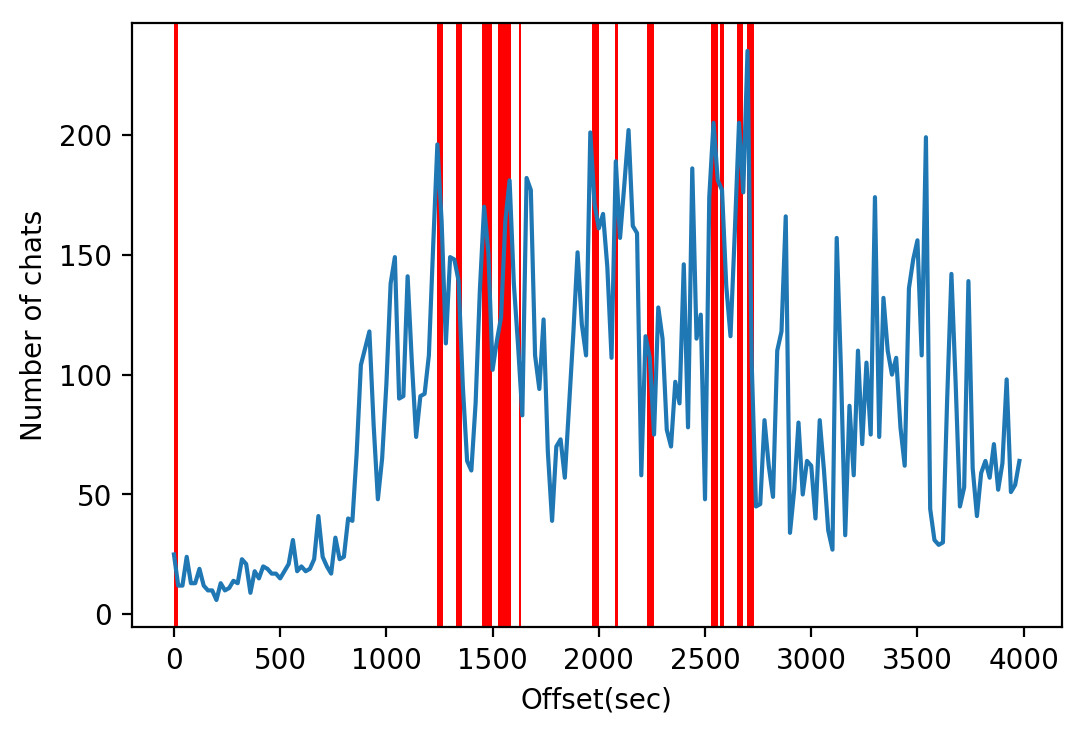

In [57]:
def plot_chats_density(chats, clips, video_length, sample_window_size, chats_density):
    fig = plt.figure(dpi=200)
    plt.xlabel("Offset(sec)")
    plt.ylabel("Number of chats")

    plot_x = range(0, video_length, sample_window_size)
    cut_edge = min(200, len(plot_x))
    
    for clip in clips:
        if clip.video_offset + clip.duration < cut_edge * sample_window_size:
            plt.axvspan(clip.video_offset, clip.video_offset + clip.duration, facecolor='r')
    plt.plot(plot_x[:cut_edge], chats_density[:cut_edge])
    return fig

chats_density = twitch_feature.calculate_chats_density(chats, video_length, sample_window_size)
plot_chats_density(chats, video_related_clips, video_length, sample_window_size, chats_density)
plt.show()

Thre red areas are highlight moments. We can see that in most cases highlight moments occur with chats density peaks. And another thing may be important is that comparing with the whole video, the total duration of highlight moments is short.

Another idea about highlight moments is that highlight moments may make some viewers usually don't send chats send chats. We define another feature to describe this assumption. We call it active user density, it means how many users speak in a window.

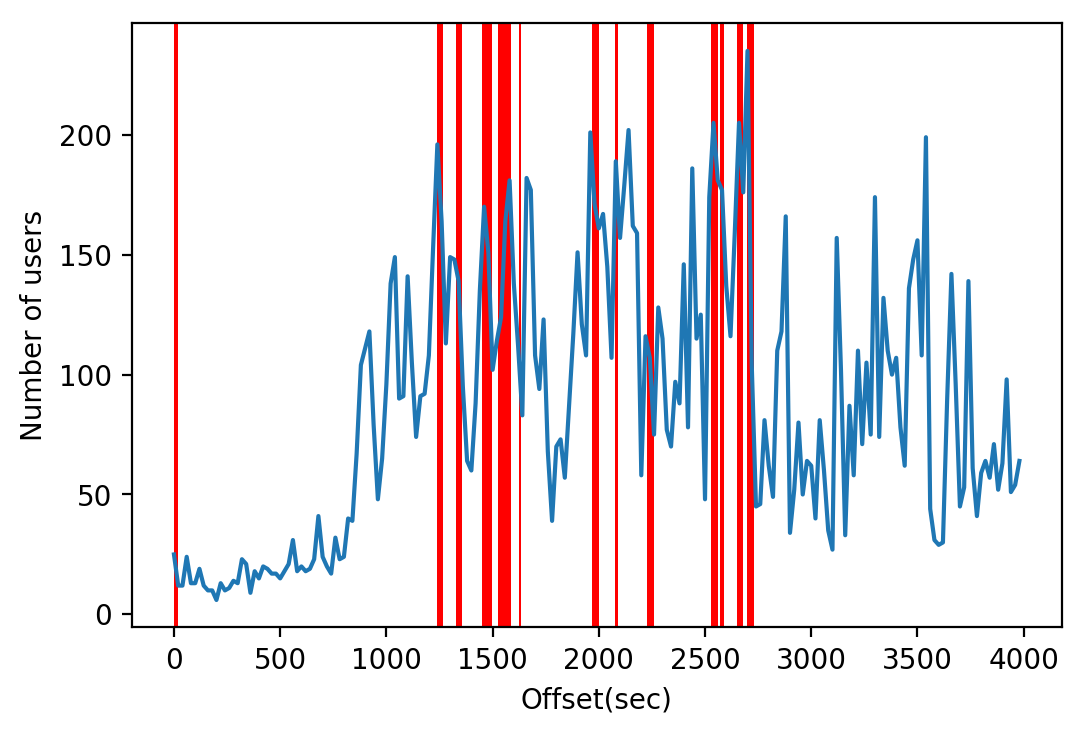

In [58]:
def plot_active_user_density(chats, clips, video_length, sample_window_size, activer_user_density):
    fig = plt.figure(dpi=200)
    plt.xlabel("Offset(sec)")
    plt.ylabel("Number of users")

    plot_x = range(0, video_length, sample_window_size)    
    cut_edge = min(200, len(plot_x))
    
    for clip in clips:
        if clip.video_offset + clip.duration < cut_edge * sample_window_size:
            plt.axvspan(clip.video_offset, clip.video_offset + clip.duration, facecolor='r')
    plt.plot(plot_x[:cut_edge], chats_density[:cut_edge])
    return fig

activer_user_density = twitch_feature.calculate_active_user_density(chats, video_length, sample_window_size)
plot_active_user_density(chats, video_related_clips, video_length, sample_window_size, activer_user_density)
plt.show()

We can see that in most cases highlight moments occur with active user density peaks.

Beyond data visualization, let's also see if there is statistical difference between highlight moments and other parts of the video.

In [11]:
labels = twitch_feature.calculate_label(video_related_clips, video_length, sample_window_size)

In [12]:
print("Clip average # of chats:", np.mean(chats_density[labels == 1]))
print("Other parts average # of chats:", np.mean(chats_density[labels == 0]))
print("Clip variance of # of chats:", np.var(chats_density[labels == 1]))
print("Other parts variance of # of chats:", np.var(chats_density[labels == 0]))
print("Clip average # of active users:", np.mean(chats_density[labels == 1]))
print("Other parts average # of active users:", np.mean(activer_user_density[labels == 0]))
print("Clip variance of # of active users:", np.var(activer_user_density[labels == 1]))
print("Other parts variance of # of active users:", np.var(activer_user_density[labels == 0]))

Clip average # of chats: 152.70967741935485
Other parts average # of chats: 102.96218487394958
Clip variance of # of chats: 2543.0366805411027
Other parts variance of # of chats: 3343.2968893439734
Clip average # of active users: 152.70967741935485
Other parts average # of active users: 98.79131652661064
Clip variance of # of active users: 2310.5120805150887
Other parts variance of # of active users: 3059.6469273984103


We can see that the average of chats density and active user density of highlight is significantly greater than other parts. So we have reasons to believe these two feature may be helpful for us to find highlight moments.
 
Another idea is that words viewers use in highlight moments may be different from usual. For example, when a player does some incrediable operations, viewers may send the player's name. So word frequency analysis may be good for our purpose. Here we use TF-IDF to describe it because there are always some dummy words like lol, lul in chats, so bags of words model doesn't work well in this case.

In [26]:
texts = twitch_feature.extract_text(chats, video_length, sample_window_size)
vectorizer, tfidf_features = twitch_feature.train_and_transform_tfidf(texts)

In [34]:
from sklearn.metrics.pairwise import cosine_similarity

print("Cos similarity between clips \t\t\t%f" % np.mean(cosine_similarity(tfidf_features[labels == 1], tfidf_features[labels == 1])))
print("Cos similarity between clips and unclips \t%f" % np.mean(cosine_similarity(tfidf_features[labels == 1], tfidf_features[labels == 0])))
print("Cos similarity between unclips \t\t\t%f" %np.mean(cosine_similarity(tfidf_features[labels == 0], tfidf_features[labels == 0])))

Cos similarity between clips 			0.121497
Cos similarity between clips and unclips 	0.089021
Cos similarity between unclips 			0.080610


We can find that average cos similarity between highlight moments is greater. So words viewers use in highlight moments may have some properties.

Furthermore, let's see the overlap between high-frequency words in highlight moments and other parts.

In [59]:
from wordcloud import WordCloud
from collections import Counter

clip_concat_feature = np.asarray(np.sum(tfidf_features[labels == 1], axis=0)).squeeze()
unclip_concnat_feature = np.asarray(np.sum(tfidf_features[labels == 0], axis=0)).squeeze()
index2word = {v:k for k,v in vectorizer.vocabulary_.items()}
clip_chats_counter = {}
unclip_chats_counter = {}
for i in index2word:
    clip_chats_counter[index2word[i]] = clip_concat_feature[i]
    unclip_chats_counter[index2word[i]] = unclip_concnat_feature[i]

In [60]:
a = sorted(list(clip_chats_counter.items()), key=lambda x: -x[1])
b = sorted(list(unclip_chats_counter.items()), key=lambda x: -x[1])
for top in [10, 50, 100]:
    overlap = 0
    top_word_a = [tu[0] for tu in a[:top]]
    top_word_b = [tu[0] for tu in b[:top]]
    for word in top_word_a:
        if word in top_word_b:
            overlap += 1
    print("Top %d\toverlap:\t" % top, overlap,'/',top,"\t", overlap/top)

Top 10	overlap:	 7 / 10 	 0.7
Top 50	overlap:	 35 / 50 	 0.7
Top 100	overlap:	 74 / 100 	 0.74


What's more, let's see wordcloud of highlight moments and other parts.

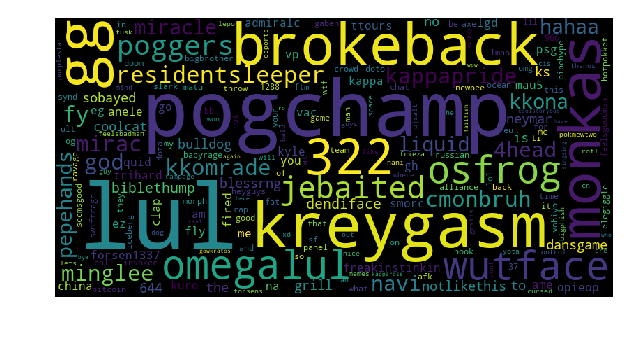

In [48]:
clip_wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(clip_chats_counter)

plt.figure(dpi=120)
plt.imshow(clip_wordcloud)
plt.axis("off")
plt.show()

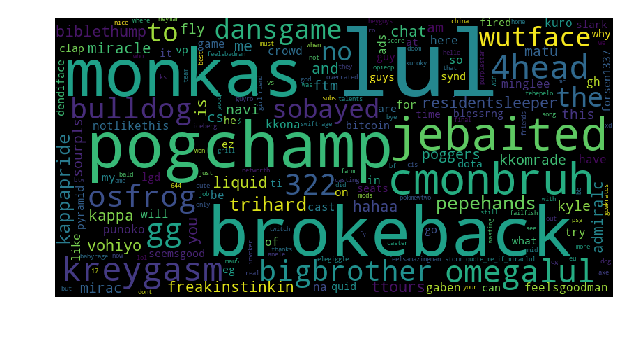

In [49]:
unclip_wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(unclip_chats_counter)

plt.figure(dpi=120)
plt.imshow(unclip_wordcloud)
plt.axis("off")
plt.show()

In [ ]:

def twitch_play_video(video_id, offset):
    html_str = '<iframe src="https://player.twitch.tv/?autoplay=false&t=%ds&video=%s" frameborder="0" allowfullscreen="true" scrolling="no" height="378" width="620"></iframe>' % (offset, video_id)
    return HTML(data=html_str)

twitch_play_video(video_id, related_clips[0].video_offset)